In [1]:
# Creating a toy multi-class dataset
import torch
import matplotlib.pyplot as plt 
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import numpy as np
from torch import nn

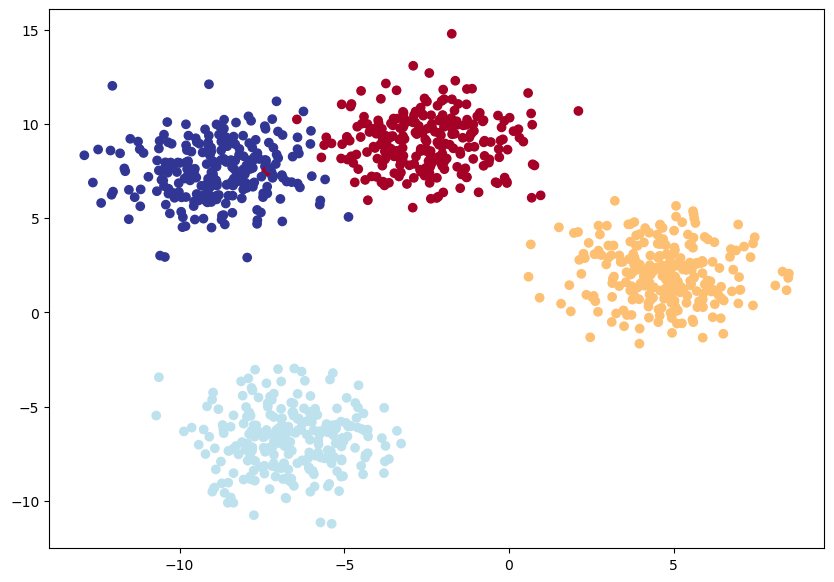

In [2]:
NUM_CLASSES =  4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap='RdYlBu')

In [3]:
# Create device agnostic code
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

mps


In [4]:
#Build a model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

In [5]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

In [6]:
model_1 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)
model_1.to(device)
next(model_1.parameters()).device

device(type='mps', index=0)

In [7]:
loss_fn = nn.CrossEntropyLoss()

In [8]:
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [9]:
model_1.eval()
with torch.inference_mode():
    y_logits = model_1(X_test.to(device))

y_logits[:10]

tensor([[-0.7183, -0.3899,  0.4558, -0.6165],
        [-0.1332, -0.9634, -0.1944, -0.9955],
        [-0.5526, -0.5805,  0.3535, -0.5354],
        [-0.2952, -0.1660,  0.1050, -0.2800],
        [-0.7810, -0.8056,  0.2333, -0.9462],
        [-0.1741, -1.1789, -0.2085, -1.2107],
        [-0.3987, -0.3941,  0.3116, -0.4165],
        [-0.4686, -0.7684,  0.0239, -0.8408],
        [-0.6121, -0.8327,  0.2669, -0.6826],
        [-0.5703, -0.7649,  0.0944, -0.8601]], device='mps:0')

In [10]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2,
        2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2,
        0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
        2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 0, 2, 2, 0, 2, 2, 2], device='mps:0')

In [11]:
epochs = 200
train_losses = np.zeros(epochs)
test_losses = np.zeros(epochs)
torch.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    #Forward Pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    #Compute Loss
    loss = loss_fn(y_logits, y_train)

    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    #Optimizer zero grad
    optimizer.zero_grad()

    #Loss Backward (Back Props)
    loss.backward()

    #Optimizer step (Gradient Step)
    optimizer.step()

    #Testing
    model_1.eval()
    with torch.inference_mode():
        #Forward Pass
        test_logits = model_1(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        #Compute Loss
        test_loss = loss_fn(test_logits, y_test)

        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    train_losses[epoch] = loss.item()
    test_losses[epoch] = test_loss.item()
    
    #Print out what is happening
    if epoch % 10 == 0:
        print(f"Epoch : {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}")

Epoch : 0 | Loss: 1.41662, Acc: 24.62 | Test Loss: 1.19578, Test Acc: 51.00
Epoch : 10 | Loss: 0.56795, Acc: 97.75 | Test Loss: 0.49460, Test Acc: 98.50
Epoch : 20 | Loss: 0.27319, Acc: 99.12 | Test Loss: 0.23097, Test Acc: 99.50
Epoch : 30 | Loss: 0.12238, Acc: 99.12 | Test Loss: 0.10622, Test Acc: 99.50
Epoch : 40 | Loss: 0.07509, Acc: 99.25 | Test Loss: 0.06516, Test Acc: 99.50
Epoch : 50 | Loss: 0.05650, Acc: 99.25 | Test Loss: 0.04788, Test Acc: 99.50
Epoch : 60 | Loss: 0.04721, Acc: 99.25 | Test Loss: 0.03880, Test Acc: 99.50
Epoch : 70 | Loss: 0.04178, Acc: 99.25 | Test Loss: 0.03331, Test Acc: 99.50
Epoch : 80 | Loss: 0.03829, Acc: 99.25 | Test Loss: 0.02968, Test Acc: 99.50
Epoch : 90 | Loss: 0.03587, Acc: 99.12 | Test Loss: 0.02710, Test Acc: 99.50
Epoch : 100 | Loss: 0.03411, Acc: 99.12 | Test Loss: 0.02519, Test Acc: 99.50
Epoch : 110 | Loss: 0.03278, Acc: 99.12 | Test Loss: 0.02371, Test Acc: 99.50
Epoch : 120 | Loss: 0.03175, Acc: 99.12 | Test Loss: 0.02254, Test Acc: 99.

In [12]:
from helper_functions import plot_predictions, plot_decision_boundary

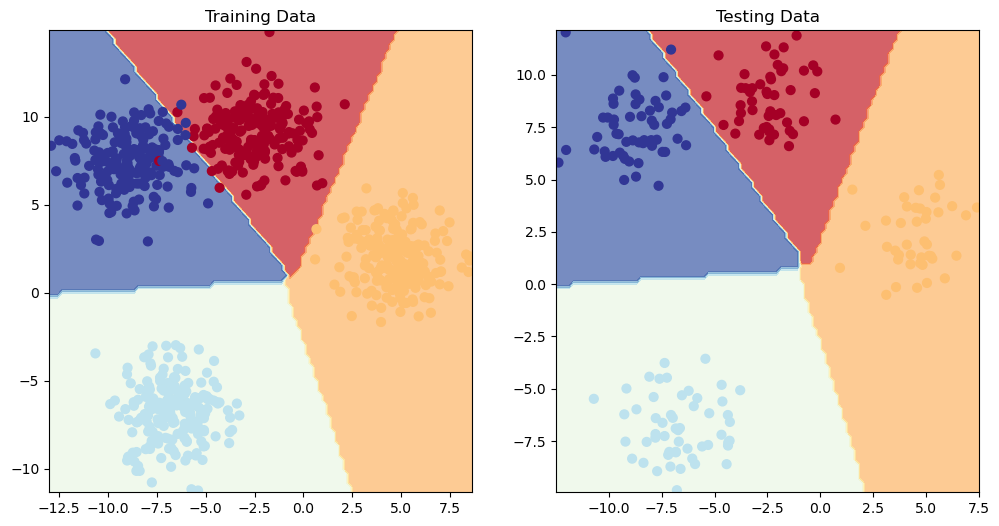

In [13]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Training Data")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Testing Data")
plot_decision_boundary(model_1, X_test, y_test)

In [26]:
model_1.to(device)
next(model_1.parameters()).device

model_1.eval()
with torch.inference_mode():
    y_logits = model_1(X_test)
    print(y_logits[:10])
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_preds = torch.argmax(y_pred_probs, dim=1)

y_preds


tensor([[ -1.9946,   6.7688,  -2.3838,  -2.9447],
        [ -3.9227,  -8.6288,  -5.4066,   3.2777],
        [-10.8371,  -2.8622,   5.4206,  -2.7876],
        [ -1.6587,   4.8407,  -1.4210,  -1.8160],
        [  5.5213,  -3.0348,  -5.3541,  -1.5420],
        [ -5.3135, -10.5116,  -6.1581,   3.9756],
        [ -8.7123,  -2.1494,   4.5158,  -2.5251],
        [  5.7922,  -4.4097,  -4.9045,  -1.1551],
        [-15.6283,  -4.7509,   6.8321,  -2.6044],
        [  5.8578,  -4.0428,  -4.8410,  -1.3103]], device='mps:0')


tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='mps:0')

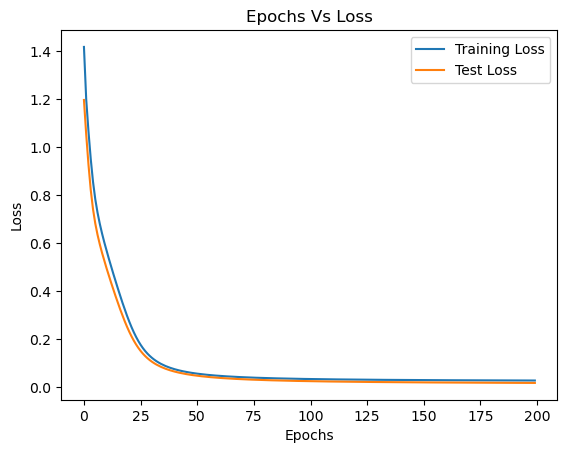

In [27]:
# Plotting the train and test loss
plt.plot(range(epochs),train_losses,label="Training Loss")
plt.plot(range(epochs),test_losses,label="Test Loss")
plt.title("Epochs Vs Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();